In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from functools import partial
import numpy as np
import math
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_dir = "/content/drive/MyDrive/TT/tfrecords"
BATCH_SIZE = 4
IMAGE_SIZE = [640, 640]
AUTOTUNE = tf.data.AUTOTUNE
GRID_SIZE = 8

In [ ]:
train_filenames = tf.io.gfile.glob(data_dir + "/train*")
val_filenames = tf.io.gfile.glob(data_dir + "/test*")
raw_train = tf.data.TFRecordDataset(train_filenames)

In [ ]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.uint8)
    image = tf.reshape(image, [*IMAGE_SIZE])
    return image
    #inverted_image = tf.bitwise.invert(image)
    #return inverted_image

In [ ]:
def bbox_gen(x1, y1, x2, y2):
    x1 = x1.numpy().tolist()
    x2 = x2.numpy().tolist()
    y1 = y1.numpy().tolist()
    y2 = y2.numpy().tolist()
    Y = np.zeros((80, 80, 5), dtype=np.float32)
    for i in range(len(x1)):
        mx, my = math.floor((x1[i]*640) // GRID_SIZE), math.floor((y1[i]*640) // GRID_SIZE)
        if mx == 160:
            mx = 159
        if my == 160:
            my = 159
        channels = Y[my][mx]
        channels[0] = 1.0
        channels[1] = math.floor(x1[i]*640) - (mx*GRID_SIZE)
        channels[2] = math.floor(y1[i]*640) - (my*GRID_SIZE)
        channels[3] = math.floor(x2[i]*640) - (mx*GRID_SIZE)
        channels[4] = math.floor(y2[i]*640) - (my*GRID_SIZE)
    return Y

In [ ]:
def read_tfrecord(example):
    tfrecord_format = (
    {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width':  tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    })
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image/encoded"])
    x1 = example['image/object/bbox/xmin']
    x2 = example['image/object/bbox/xmax']
    y1 = example['image/object/bbox/ymin']
    y2 = example['image/object/bbox/ymax']
    bboxes = tf.py_function(func=bbox_gen, inp=[x1, y1, x2, y2], Tout=tf.float32)
    return image, bboxes

In [ ]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = (dataset
                .cache()
                .shuffle(BATCH_SIZE, reshuffle_each_iteration=True)
                .batch(BATCH_SIZE)
                .prefetch(buffer_size=AUTOTUNE)
                .repeat(4))
    return dataset

In [ ]:
train = get_dataset(train_filenames)
val = get_dataset(val_filenames)

In [ ]:
image_batch_val = next(iter(val))

In [ ]:
def show_predict(X, y_true, threshold=0.7):
    X = X.numpy().copy()
    y = model.predict(X)
    plt.figure(figsize=(50,50))
    for n in range(4):
        Xrgb = cv2.cvtColor(X[n], cv2.COLOR_GRAY2RGB)
        y_pred = y[n]
        single_y_true = y_true.numpy()[n]

        ax = plt.subplot(4, 4, n + 1)
        plt.axis("off")
    
        for mx in range(80):
            for my in range(80):
                channels = y_pred[my][mx]
                channelst = single_y_true[my][mx]
                prob, x1, y1, x2, y2 = channels
                tprob, tx1, ty1, tx2, ty2 = channelst
                # if prob < threshold we won't show any thing
                if prob < threshold:
                    continue

                # bounding box pred
                px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)
                # bounding box true
                px1t, py1t = (mx * GRID_SIZE) + tx1, (my * GRID_SIZE) + ty1
                px2t, py2t = (mx * GRID_SIZE) + tx2, (my * GRID_SIZE) + ty2
                cv2.rectangle(Xrgb, (int(px1t), int(py1t)), (int(px2t), int(py2t)), (0,255,0), 2)
                #print(int(px), int(py), int(px + x2), int(py + y2))
        plt.imshow(Xrgb)

In [ ]:
def show_boxes(image_batch):
    xs, ys = image_batch
    xs = xs.numpy()
    plt.figure(figsize=(50,50))
    for n in range(BATCH_SIZE):
        Xrgb = cv2.cvtColor(xs[n], cv2.COLOR_GRAY2RGB)
        y = ys[n]

        ax = plt.subplot(4, 4, n + 1)
        plt.axis("off")
    
        for mx in range(80):
            for my in range(80):
                channels = y[my][mx]
                prob, x1, y1, x2, y2 = channels
                if prob == 1:
                # bounding box pred
                    px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                    px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                    cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)
        plt.imshow(Xrgb)

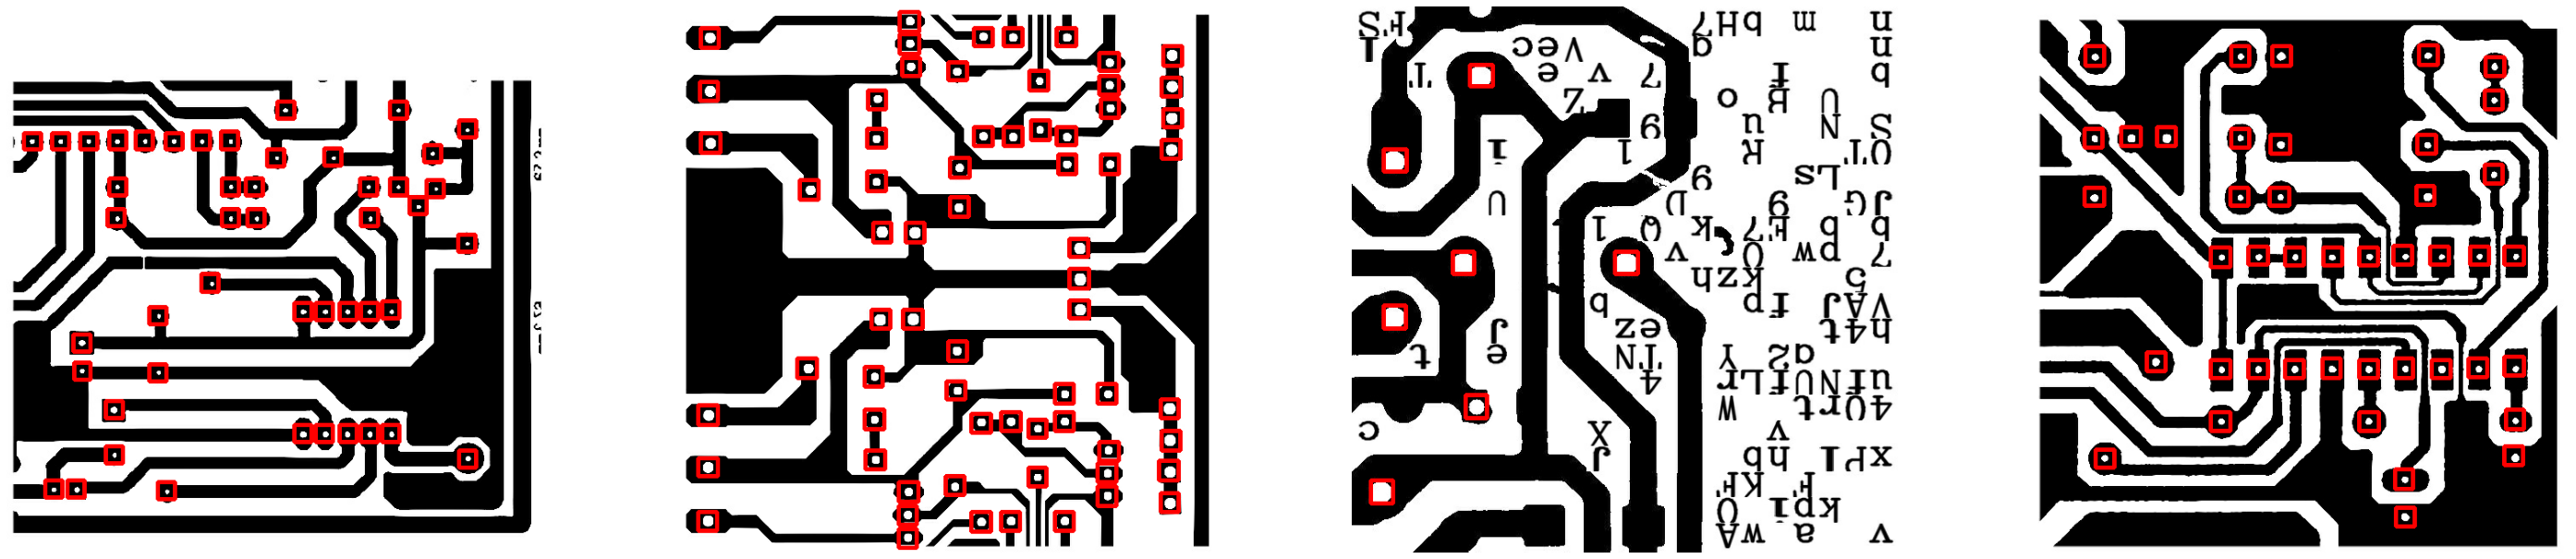

In [ ]:
show_boxes(image_batch_val)

# Model

In [ ]:
x = x_input = tf.keras.layers.Input(shape=(640, 640, 1))

y = tf.keras.layers.Conv2D(32, kernel_size=16, strides=(8,8), padding="same", activation='sigmoid')(x)
#y = tf.keras.layers.BatchNormalization()(y)

x = tf.keras.layers.Conv2D(32, kernel_size=6, padding='same', activation='relu')(x)
#x = tf.keras.layers.Dropout(.1)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x) # size: 160x160

#x = tf.keras.layers.Conv2D(15, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.15))(x)
x = tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='sigmoid')(x)
x = tf.keras.layers.AvgPool2D(pool_size=(4,4))(x)
#x = tf.keras.layers.Dropout(.15)(x)
#x = tf.keras.layers.BatchNormalization()(x)  # size: 80x80

x = tf.keras.layers.Concatenate()([x,y])
x = tf.keras.layers.Dropout(.05)(x)
# ---

x_prob = tf.keras.layers.Conv2D(1, kernel_size=10, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = tf.keras.layers.Conv2D(4, kernel_size=10, padding='same', name='x_boxes')(x)

# ---

gate = tf.where(x_prob > 0.4, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate

# ---

x = tf.keras.layers.Concatenate()([x_prob, x_boxes])

model = tf.keras.models.Model(x_input, x)

In [ ]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.huber(y_true, y_pred)
    return tf.reduce_mean(loss)

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.0006)
model.compile(loss=loss_func, optimizer=opt)

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self):
        super(EarlyStoppingAtMinLoss, self).__init__()
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get("val_loss")

        if current_val_loss <= 40:
            self.model.save('TTmodel.h5', overwrite=True)
            self.stopped_epoch = epoch
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
best_weights_callback = tf.keras.callbacks.ModelCheckpoint(
    "training_2/",
    monitor='val_loss',
    save_weights_only=True,
)

In [ ]:
history = model.fit(train, validation_data=val, epochs=50, callbacks=[EarlyStoppingAtMinLoss(), best_weights_callback])

Epoch 1/50
312/312 [==============================] - 15s 44ms/step - loss: 700.6469 - val_loss: 449.8961
Epoch 2/50
312/312 [==============================] - 13s 42ms/step - loss: 336.0866 - val_loss: 309.9119
Epoch 3/50
312/312 [==============================] - 14s 43ms/step - loss: 278.5303 - val_loss: 281.8048
Epoch 4/50
312/312 [==============================] - 13s 42ms/step - loss: 261.4650 - val_loss: 268.7387
Epoch 5/50
312/312 [==============================] - 13s 42ms/step - loss: 247.7566 - val_loss: 259.3391
Epoch 6/50
312/312 [==============================] - 13s 42ms/step - loss: 238.3278 - val_loss: 251.1262
Epoch 7/50
312/312 [==============================] - 13s 43ms/step - loss: 231.5615 - val_loss: 245.3112
Epoch 8/50
312/312 [==============================] - 13s 42ms/step - loss: 226.2171 - val_loss: 239.3536
Epoch 9/50
312/312 [==============================] - 13s 42ms/step - loss: 219.5955 - val_loss: 231.9946
Epoch 10/50
312/312 [=========================

In [ ]:
def show_predict(X, y_true, threshold=0.45):
    X = X.numpy().copy()
    y = model.predict(X)
    plt.figure(figsize=(50,50))
    for n in range(BATCH_SIZE):
        Xrgb = cv2.cvtColor(X[n], cv2.COLOR_GRAY2RGB)
        y_pred = y[n]
        single_y_true = y_true.numpy()[n]

        ax = plt.subplot(4, 2, n + 1)
        plt.axis("off")
    
        for mx in range(80):
            for my in range(80):
                channels = y_pred[my][mx]
                channelst = single_y_true[my][mx]
                prob, x1, y1, x2, y2 = channels
                tprob, tx1, ty1, tx2, ty2 = channelst

                if tprob == 1.0:
                    # bounding box true
                    px1t, py1t = (mx * GRID_SIZE) + tx1, (my * GRID_SIZE) + ty1
                    px2t, py2t = (mx * GRID_SIZE) + tx2, (my * GRID_SIZE) + ty2
                    cv2.rectangle(Xrgb, (int(px1t), int(py1t)), (int(px2t), int(py2t)), (0,255,0), 2)
                # if prob < threshold we won't show any thing
                if prob < threshold:
                    continue

                # bounding box pred
                px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)

                #print(int(px), int(py), int(px + x2), int(py + y2))
        plt.imshow(Xrgb)

In [ ]:
image_batch, y_batch = next(iter(val))

1/1 [==============================] - 0s 20ms/step


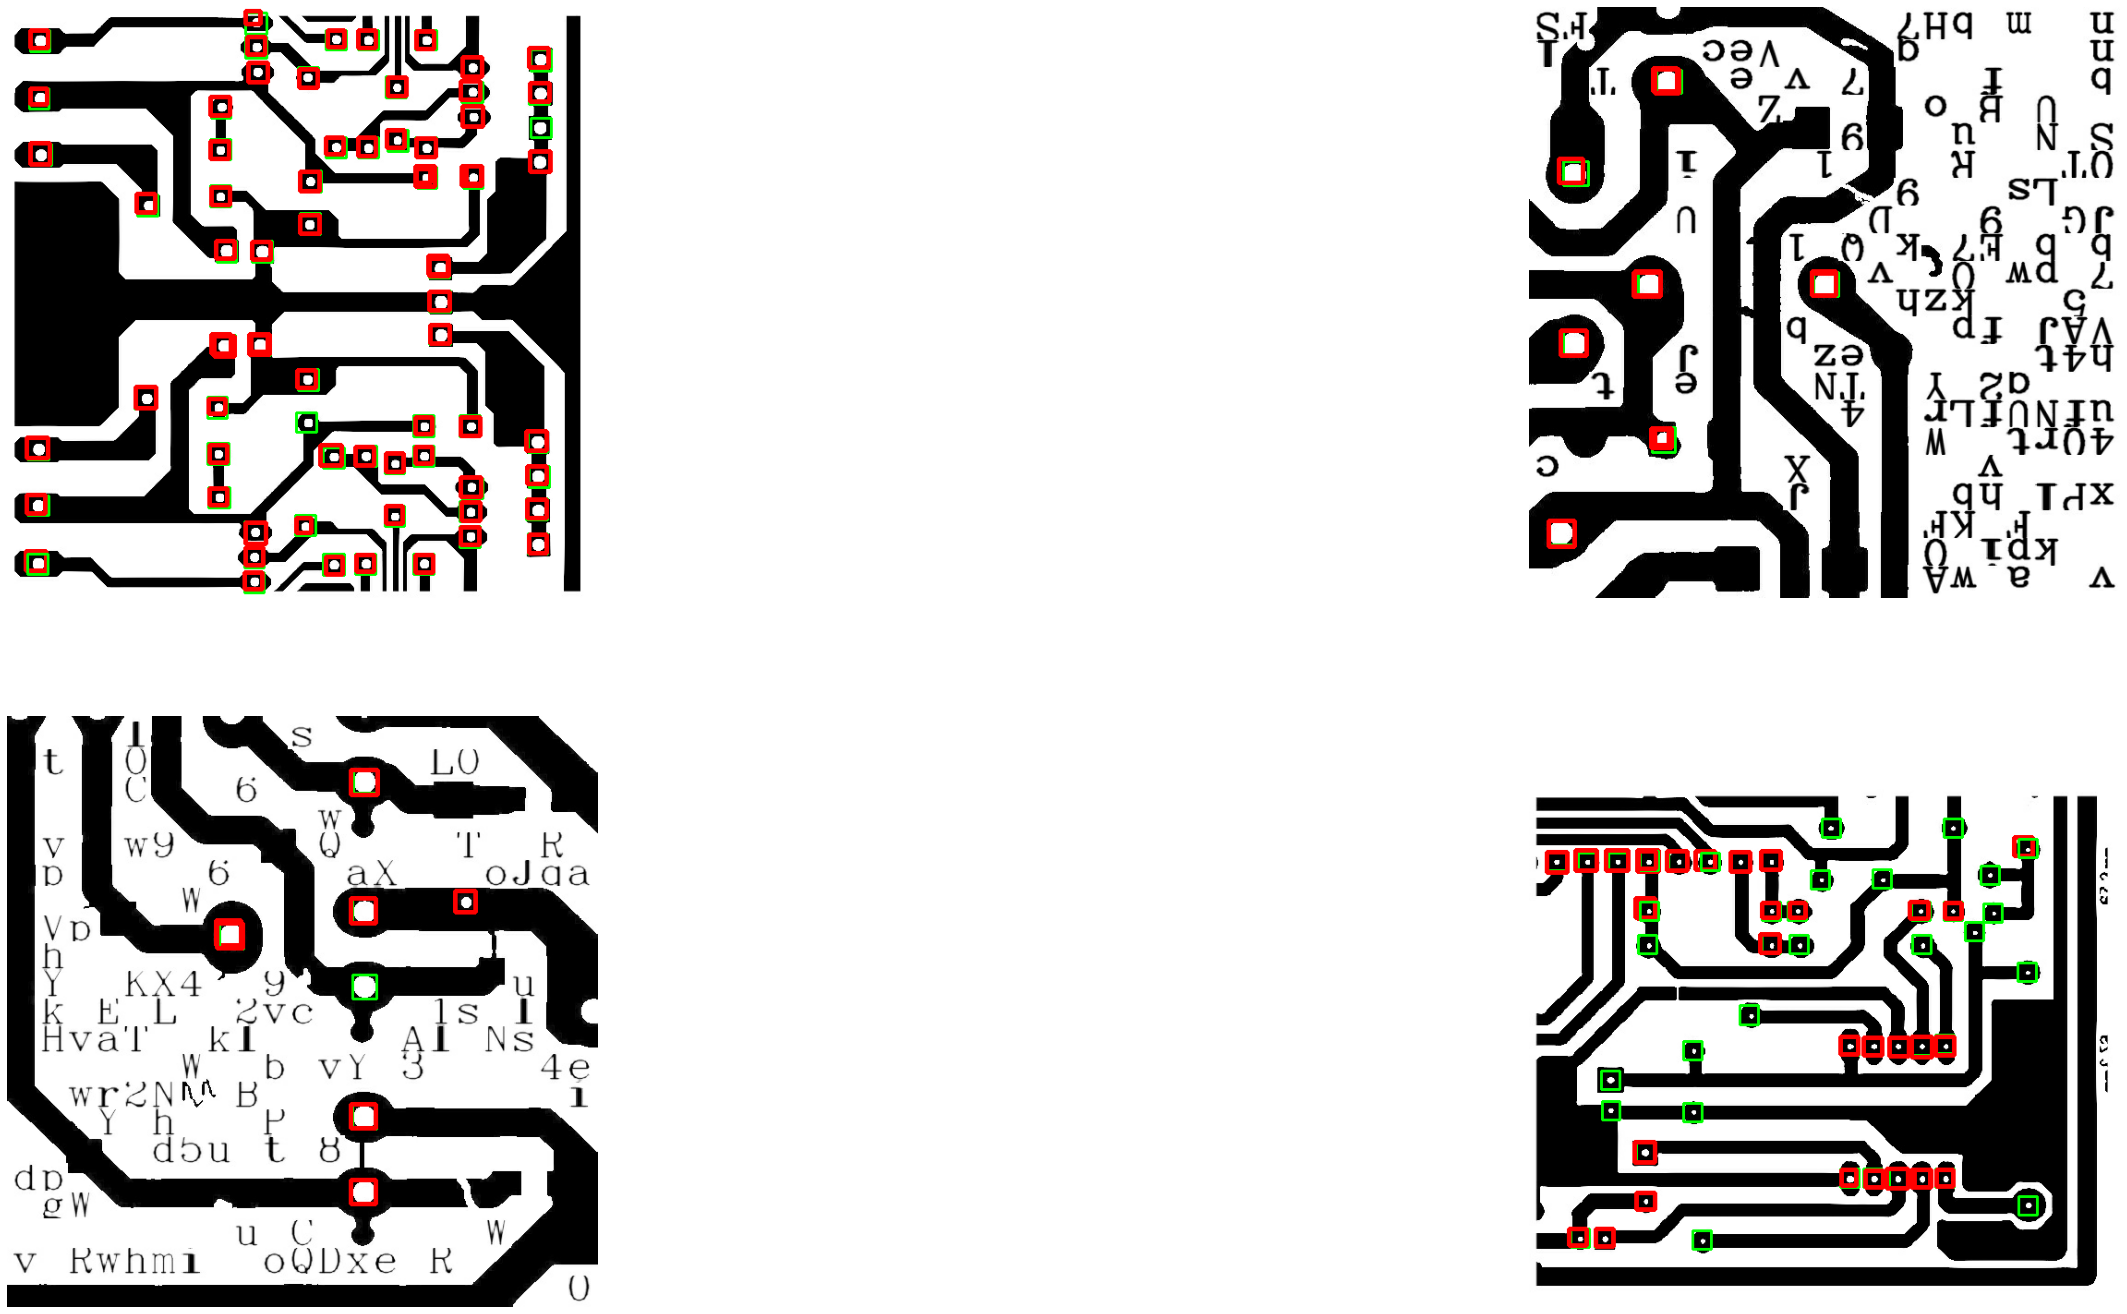

In [ ]:
show_predict(image_batch, y_batch)

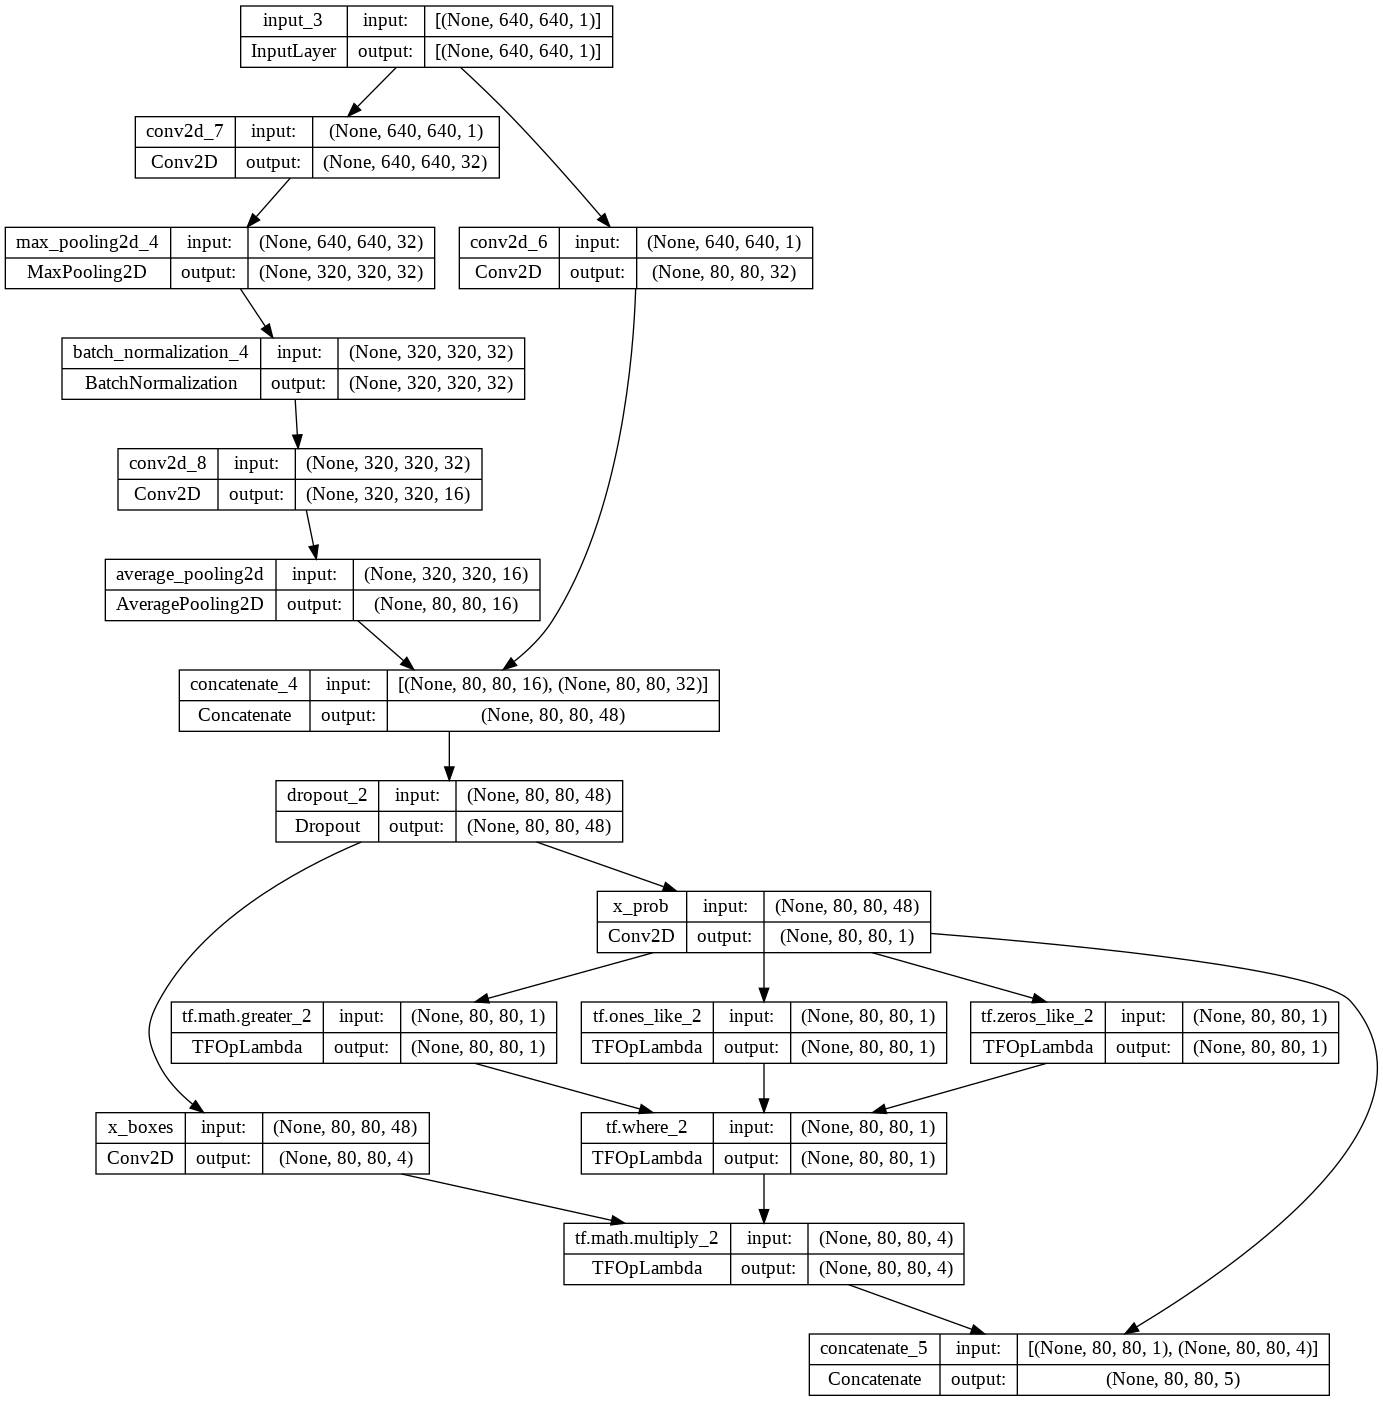

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.save("model_original_idea_best.h5")

Text(0.5, 0, 'epoch')

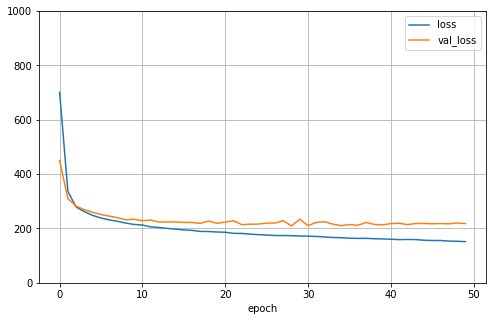

In [ ]:
import pandas as pd
# plotting the measurments in the history object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1000)
plt.xlabel("epoch")

In [ ]:
# Loads the weights
model.load_weights("./cp.ckpt")

NotFoundError: ignored

In [ ]:
img = tf.keras.utils.load_img(
    "./imp.jpg", target_size=(640,640)
)
img_array = tf.keras.utils.img_to_array(img)
gray = img_array[:,:,0]
gray = tf.expand_dims(gray, 0) # Create a batch

predictions = model.predict(gray)